# Examples and use cases for the cluster_dag module

In [1]:
from clustcausal.clusterdag.cluster_dag import CDAG

In [2]:
# Define a cluster DAG
cluster_dict = {}
cluster_dict['clusters'] = {'C1':['X1','X2','X3'], 'C2': ['X4','X5'], 'C3':['X6','X7'], 'C4':['X8','X9']}
cluster_dict['cluster_edges'] = [('C1','C3'), ('C2','C3'), ('C3','C4'), ('C2','C4')] 
cdag = CDAG(cluster_mapping=cluster_dict['clusters'], cluster_edges = cluster_dict['cluster_edges'])

2023-06-24 13:38:41,614 - c:\Users\JanMarco\MLProjects\Masterthesis\masterthesis\clustcausal\clusterdag\cluster_dag.py[line:69] - INFO: removed edge: (C1,C2)
2023-06-24 13:38:41,615 - c:\Users\JanMarco\MLProjects\Masterthesis\masterthesis\clustcausal\clusterdag\cluster_dag.py[line:73] - INFO: oriented edge: (C1,C3)
2023-06-24 13:38:41,615 - c:\Users\JanMarco\MLProjects\Masterthesis\masterthesis\clustcausal\clusterdag\cluster_dag.py[line:69] - INFO: removed edge: (C1,C4)
2023-06-24 13:38:41,616 - c:\Users\JanMarco\MLProjects\Masterthesis\masterthesis\clustcausal\clusterdag\cluster_dag.py[line:73] - INFO: oriented edge: (C2,C3)
2023-06-24 13:38:41,616 - c:\Users\JanMarco\MLProjects\Masterthesis\masterthesis\clustcausal\clusterdag\cluster_dag.py[line:73] - INFO: oriented edge: (C2,C4)
2023-06-24 13:38:41,617 - c:\Users\JanMarco\MLProjects\Masterthesis\masterthesis\clustcausal\clusterdag\cluster_dag.py[line:73] - INFO: oriented edge: (C3,C4)


In [3]:
print(cdag.get_cluster_topological_ordering())

['C1', 'C2', 'C3', 'C4']


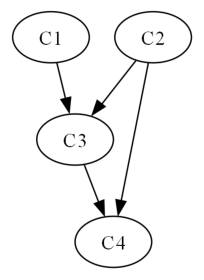

In [4]:
cdag.draw_cluster_graph()

2023-06-24 13:38:41,895 - c:\Users\JanMarco\MLProjects\Masterthesis\masterthesis\clustcausal\clusterdag\cluster_dag.py[line:95] - INFO: removed edge: (X1,X4)
2023-06-24 13:38:41,896 - c:\Users\JanMarco\MLProjects\Masterthesis\masterthesis\clustcausal\clusterdag\cluster_dag.py[line:95] - INFO: removed edge: (X1,X5)
2023-06-24 13:38:41,896 - c:\Users\JanMarco\MLProjects\Masterthesis\masterthesis\clustcausal\clusterdag\cluster_dag.py[line:99] - INFO: oriented edge: (X1,X6)
2023-06-24 13:38:41,897 - c:\Users\JanMarco\MLProjects\Masterthesis\masterthesis\clustcausal\clusterdag\cluster_dag.py[line:99] - INFO: oriented edge: (X1,X7)
2023-06-24 13:38:41,897 - c:\Users\JanMarco\MLProjects\Masterthesis\masterthesis\clustcausal\clusterdag\cluster_dag.py[line:95] - INFO: removed edge: (X1,X8)
2023-06-24 13:38:41,898 - c:\Users\JanMarco\MLProjects\Masterthesis\masterthesis\clustcausal\clusterdag\cluster_dag.py[line:95] - INFO: removed edge: (X1,X9)
2023-06-24 13:38:41,899 - c:\Users\JanMarco\MLProj

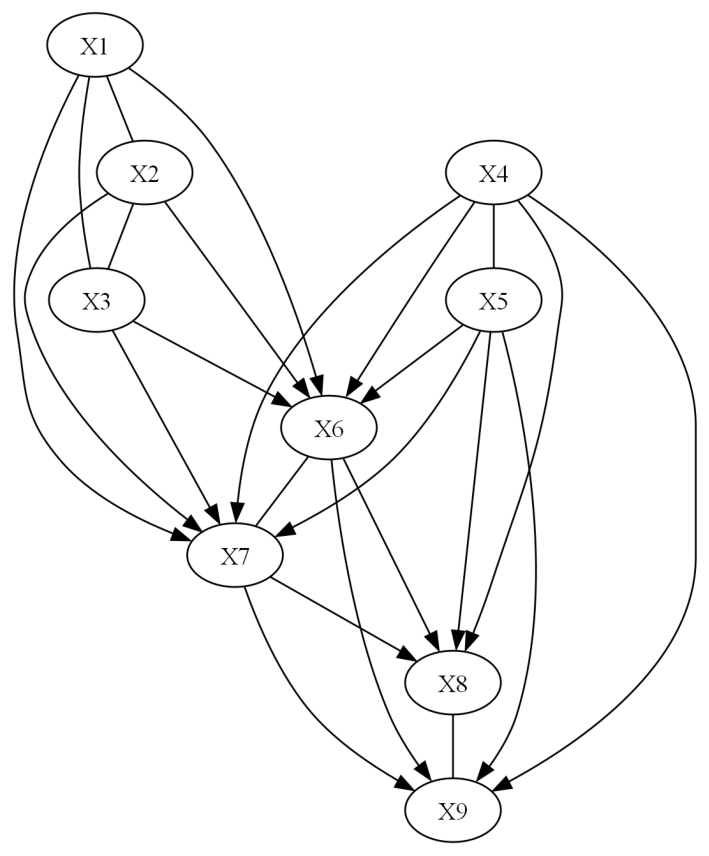

In [5]:
cdag.cdag_to_mpdag()
cdag.draw_mpdag()

### Restricting graph - example

In [14]:
cluster3 = cdag.get_node_by_name('C3', cdag.cluster_graph)
cluster3

In [15]:
c3_relevant_clusters, c3_relevant_nodes = cdag.get_parents_plus(cluster3)
print(c3_relevant_clusters)
print(c3_relevant_nodes)

[<causallearn.graph.GraphNode.GraphNode object at 0x000001FD814A10C0>, <causallearn.graph.GraphNode.GraphNode object at 0x000001FD814A2560>, <causallearn.graph.GraphNode.GraphNode object at 0x000001FD814A25C0>]
[<causallearn.graph.GraphNode.GraphNode object at 0x000001FD818446D0>, <causallearn.graph.GraphNode.GraphNode object at 0x000001FD81844430>, <causallearn.graph.GraphNode.GraphNode object at 0x000001FD814C75E0>, <causallearn.graph.GraphNode.GraphNode object at 0x000001FD814C57E0>, <causallearn.graph.GraphNode.GraphNode object at 0x000001FD81845060>, <causallearn.graph.GraphNode.GraphNode object at 0x000001FD81845210>, <causallearn.graph.GraphNode.GraphNode object at 0x000001FD81844A00>]


In [16]:
clust_names = []
node_names = []
for clust in c3_relevant_clusters:
    clust_names.append(clust.get_name())
for node in c3_relevant_nodes:
    node_names.append(node.get_name())
print(clust_names, node_names)
print(cdag.cluster_mapping)

['C3', 'C1', 'C2'] ['X6', 'X7', 'X1', 'X2', 'X3', 'X4', 'X5']
{'C1': ['X1', 'X2', 'X3'], 'C2': ['X4', 'X5'], 'C3': ['X6', 'X7'], 'C4': ['X8', 'X9']}


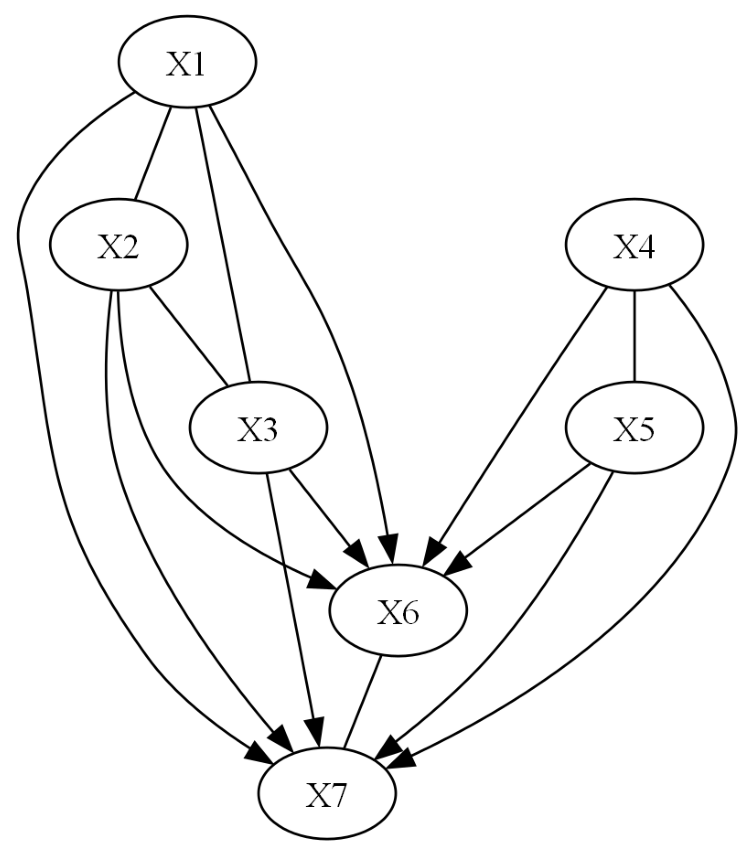

In [17]:
local_graph = cdag.get_local_graph(cluster3)
local_graph.draw_pydot_graph()